In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

## Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [6]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time \n per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time \n per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [7]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    df['Total Mem. per Conn.'] = df['VSize_mem_sum'] / df['N_conns_sum'] * 1024
    return df

In [40]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

## Benchmarks with weak scaling

### HPC Benchmark

,git,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,num_tasks,NUM_VPS,SCALE,PLASTIC,T_nrns,T_conns_min,...,T_bld_nx,Conn. Total,Conn. Creation (min),Conn. Exchange (min),N_VP,connections,ini,other,Memory per VP,Simulation time
0,GIT: (master@00e0d3cc8),1,6,6,6,36,20,True,0.47,48.05,...,101.46,101.46,48.05,52.39,36,2.739827,0.024417,0.058848,2.823093,192.24
1,GIT: (master@00e0d3cc8),2,6,6,12,72,40,True,0.46,47.96,...,103.78,103.71,47.96,54.02,72,2.739827,0.031579,0.061790,2.833196,196.59
2,GIT: (master@00e0d3cc8),4,6,6,24,144,80,True,0.60,48.01,...,106.08,106.08,48.01,56.72,144,2.739827,0.109256,0.059368,2.908452,202.55
3,GIT: (master@00e0d3cc8),8,6,6,48,288,160,True,0.51,47.94,...,112.73,112.73,47.94,62.87,288,2.739827,0.114879,0.059380,2.914086,213.19
4,GIT: (master@00e0d3cc8),16,6,6,96,576,320,True,0.64,47.79,...,130.33,130.33,47.79,80.37,576,2.739827,0.260645,0.061470,3.061942,229.61
5,GIT: (master@00e0d3cc8),32,6,6,192,1152,640,True,0.65,48.11,...,155.52,155.52,48.11,105.41,1152,2.739827,0.589963,0.060436,3.390226,271.25
0,NaN,1,6,6,6,36,20,True,0.44,52.78,...,113.75,113.75,52.78,55.14,36,2.736654,0.019534,0.054986,2.811174,225.78
1,NaN,2,6,6,12,72,40,True,0.48,52.78,...,114.13,114.13,52.78,55.96,72,2.734538,0.023603,0.060641,2.818782,203.34
2,NaN,4,6,6,24,144,80,True,0.47,53.00,...,118.42,118.42,53.00,59.71,144,2.734538,0.110192,0.057406,2.902136,209.36
3,NaN,8,6,6,48,288,160,True,0.67,53.32,...,124.77,124.77,53.32,65.21,288,2.734538,0.113760,0.057417,2.905715,221.27


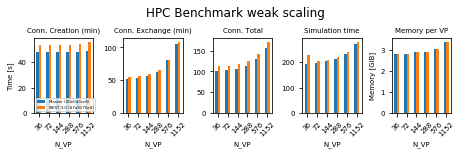

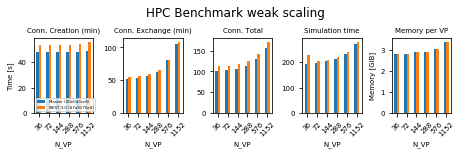

In [42]:
hpc_m = pd.read_csv('results/hpc_benchmark_00e0d3cc8_daint.csv')
hpc_m['Case'] = ['Master (00e0d3cc8)'] * len(hpc_m)
hpc_3 = pd.read_csv('results/hpc_benchmark_3_0_47a9175e4_daint.csv')
hpc_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(hpc_m)

hpc = pd.concat([hpc_m, hpc_3])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')

hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.svg', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')

hpc

### Population model

Conn. Creation (min)                      Conn. Exchange (min)  \
Case   Master (00e0d3cc8) NEST 3.0 (47a9175e4)   Master (00e0d3cc8)   
N_VP                                                                  
36              73.988831            57.905697            51.225664   
72             103.239352            69.335492            54.635508   
144            160.824204            89.550997            56.020412   
288            268.071163           130.736555            65.274719   
576                   NaN                  NaN                  NaN   
1152                  NaN                  NaN                  NaN   

                                 Conn. Total                       \
Case NEST 3.0 (47a9175e4) Master (00e0d3cc8) NEST 3.0 (47a9175e4)   
N_VP                                                                
36              45.578337         131.849916           113.009834   
72              47.704243         167.658098           126.176039   
144             51.191208         224.536495           149.590930   
288             61.675069         343.732868           206.636241   
576                   NaN                NaN                  NaN   
1152                  NaN                NaN                  NaN   

          Memory per VP                                  T_nrns  \
Case Master (00e0d3cc8) NEST 3.0 (47a9175e4) Master (00e0d3cc8)   
N_VP                                                              
36             3.420366             3.456075           0.356953   
72             3.491397             3.561793           0.245207   
144            3.737470             3.781858           0.339101   
288            3.519211             3.554878           0.652172   
576                 NaN                  NaN                NaN   
1152                NaN                  NaN                NaN   

                           
Case NEST 3.0 (47a9175e4)  
N_VP                       
36               0.131594  
72               0.075080  
144              0.106480  
288              0.170175  
576                   NaN  
1152                  NaN

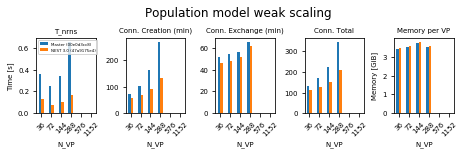

In [43]:
population_m = pd.read_csv('results/population_model_00e0d3cc8_daint_in.csv')
population_m['Case'] = ['Master (00e0d3cc8)'] * len(population_m)
population_3 = pd.read_csv('results/population_model_3_0_47a9175e4_daint_in.csv')
population_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(population_m)

population = pd.concat([population_m, population_3])

population = calculate_T_conn_and_memory(population)
population_p = plot_compare(population, 'figures/population_model_weak_scaling.pdf',
                            ['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                             'Memory per VP'],
                            plot_T_sim=False, legend_loc='upper left',
                            title='Population model weak scaling')

population_p

Conn. Creation (min)                      Conn. Exchange (min)  \
Case   Master (02a44ba55) NEST 3.0 (47a9175e4)   Master (02a44ba55)   
N_VP                                                                  
36              45.838417            36.955057            33.117212   
72              80.979914            55.495401            42.689857   
144            127.475179            72.194067            45.452307   
288            220.577045           104.732111            51.852047   
576            401.980089           173.740939            66.845750   
1152           772.252769           309.285594            99.060814   

                                 Conn. Total                       \
Case NEST 3.0 (47a9175e4) Master (02a44ba55) NEST 3.0 (47a9175e4)   
N_VP                                                                
36              29.071780          79.531162            71.925418   
72              37.857497         124.772970           100.845343   
144             41.669640         174.595567           122.426312   
288             47.426490         277.086630           160.873778   
576             64.363408         476.640818           247.792988   
1152            92.295056         889.126306           424.864993   

          Memory per VP                       
Case Master (02a44ba55) NEST 3.0 (47a9175e4)  
N_VP                                          
36             2.222356             2.236429  
72             2.934446             2.953619  
144            3.003910             3.036972  
288            2.937574             3.031440  
576            2.998694             3.031835  
1152           3.080204             3.032537

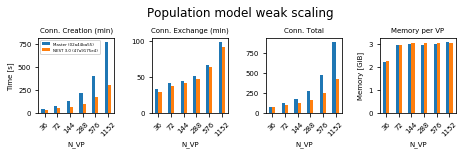

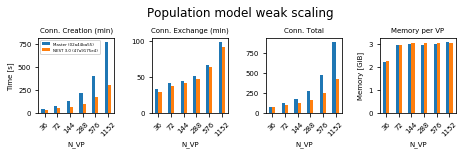

In [44]:
population_s4_m = pd.read_csv('results/population_model_02a44ba55_daint_in_scale4.csv')
population_s4_m['Case'] = ['Master (02a44ba55)'] * len(population_s4_m)
population_s4_3 = pd.read_csv('results/population_model_3_0_47a9175e4_daint_in_scale4.csv')
population_s4_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(population_s4_3)

population_s4 = pd.concat([population_s4_m, population_s4_3])

population_s4 = calculate_T_conn_and_memory(population_s4)
population_s4_p = plot_compare(population_s4, 'figures/population_model_weak_scaling_scale4.pdf',
                               ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                'Memory per VP'],
                               plot_T_sim=False, legend_loc='upper left',
                               title='Population model weak scaling')

population_s4_p = plot_compare(population_s4, 'figures/population_model_weak_scaling_scale4.svg',
                               ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                'Memory per VP'],
                               plot_T_sim=False, legend_loc='upper left',
                               title='Population model weak scaling')

population_s4_p

### Population model - `fixed_outdegree`

0     382.215893
1     661.518434
2    1210.709612
3    2270.137045
4    4397.411327
5            NaN
0     517.505644
1     926.714142
2    1740.919693
3    3344.155159
4            NaN
5            NaN
Name: T_conns_min, dtype: float64
0     396.630207
1     676.281729
2    1266.915778
3    2377.381401
4    5143.177032
5            NaN
0     657.270283
1     945.149023
2    1794.366704
3    3448.692000
4            NaN
5            NaN
Name: T_conns_max, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: T_ini_min, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: T_ini_max, dtype: float64


TypeError: Empty 'DataFrame': no numeric data to plot

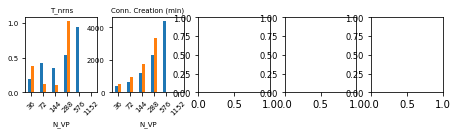

In [35]:
population_out_m = pd.read_csv('results/population_model_02a44ba55_daint_out.csv')
population_out_m['Case'] = ['Master (02a44ba55)'] * len(population_out_m)
population_out_3 = pd.read_csv('results/population_model_3_0_47a9175e4_daint_out.csv')
population_out_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(population_out_3)

population_out = pd.concat([population_out_m, population_out_3])

population_out = calculate_T_conn_and_memory(population_out)

print(population_out['T_conns_min'])
print(population_out['T_conns_max'])
print(population_out['T_ini_min'])
print(population_out['T_ini_max'])
population_out_p = plot_compare(population_out, 'figures/population_model_out_weak_scaling.pdf',
                                ['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                 'Memory per VP'],
                                plot_T_sim=False, legend_loc='upper left')

population_out_p

### Multi-Area Model

0      60539406
1     121689362
2     242533311
3     485965655
4       5574566
5    1936676440
0      60363069
1     119604230
2     242952584
3     486924029
4       5553407
5    1918935588
Name: N_spks_sum, dtype: int64
0     258258
1     516391
2    1032643
3    2065151
4    4130180
5    8260234
0     258257
1     516390
2    1032642
3    2065150
4    4130179
5    8260233
Name: N_nrns, dtype: int64


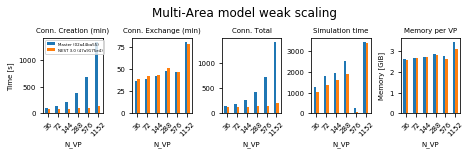

In [45]:
MAM_m = pd.read_csv('results/multi-area_model_02a44ba55_daint.csv')
MAM_m['Case'] = ['Master (02a44ba55)'] * len(MAM_m)
MAM_3 = pd.read_csv('results/multi-area_model_3_0_47a9175e4_daint.csv')
MAM_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(MAM_m)

MAM = pd.concat([MAM_m, MAM_3])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.pdf', legend_loc='upper left',
                     title='Multi-Area model weak scaling')
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.svg', legend_loc='upper left',
                     title='Multi-Area model weak scaling')

print(MAM['N_spks_sum'])
print(MAM['N_nrns'])
#print(MAM['N_conns_sum'])

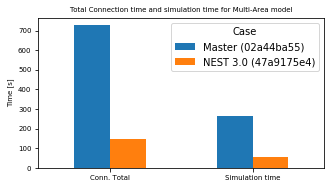

In [16]:
MAM_16 = MAM[MAM['NUMBER_OF_NODES']==16]

values = ['Conn. Total', 'Simulation time']

df_p = pd.pivot_table(MAM_16, columns='Case', values=values)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(cm2inch(13),cm2inch(7)))

df_p.plot(kind='bar', ax = axes, title='Total Connection time and simulation time for Multi-Area model',
          fontsize=fontsize_axis, rot=0)
axes.set_ylabel('Time [s]')

fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.pdf", bbox_inches='tight')

fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.svg", bbox_inches='tight')

### Topology model

NB! This is not 4x4!

,git,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,num_tasks,NUM_VPS,SCALE,count,T_nrns,T_conns_max,T_conns_min,VSize_nodes_sum,VSize_mem_sum,VSize_ini_sum,VSize_sum,N_nrns,N_conns_sum,Case,N_VP
0,NaN,1,6,6,6,36,1,NaN,3.348829,113.986795,113.986485,7961280.0,45697728.0,50453304.0,50453304.0,661029.0,6.067075e+08,Master (00e0d3cc8),36
1,NaN,2,6,6,12,72,2,NaN,7.271655,256.673565,256.665625,17810996.0,148293172.0,155750180.0,155750180.0,1321997.0,2.422275e+09,Master (00e0d3cc8),72
2,NaN,4,6,6,24,144,4,NaN,12.448437,501.132981,501.091950,46734868.0,538326548.0,553793524.0,553793524.0,2643933.0,9.680283e+09,Master (00e0d3cc8),144
3,NaN,8,6,6,48,288,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Master (00e0d3cc8),288
0,NaN,1,6,6,6,36,1,NaN,3.769301,90.976650,90.976173,9456928.0,40725024.0,47372952.0,47372952.0,660968.0,6.067161e+08,NEST 3.0 (47a9175e4),36
1,NaN,2,6,6,12,72,2,NaN,7.491998,267.703830,267.682693,21097972.0,151196660.0,159261924.0,159261924.0,1321936.0,2.422389e+09,NEST 3.0 (47a9175e4),72
2,NaN,4,6,6,24,144,4,NaN,13.790759,631.175217,631.108117,50650516.0,569217940.0,579097972.0,579097972.0,2643872.0,9.680669e+09,NEST 3.0 (47a9175e4),144
3,NaN,8,6,6,48,288,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEST 3.0 (47a9175e4),288


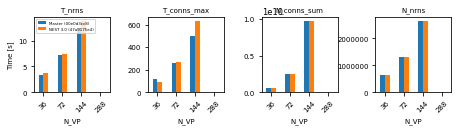

In [13]:
topology_m = pd.read_csv('results/topology_model_00e0d3cc8_daint.csv')
topology_m['Case'] = ['Master (00e0d3cc8)'] * len(topology_m)
topology_3 = pd.read_csv('results/topology_model_3_0_47a9175e4_daint.csv')
topology_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(topology_3)

topology = pd.concat([topology_m, topology_3])

#topology = calculate_T_conn_and_memory(topology)

topology['N_VP'] = topology['NUM_VPS']

topology_p = plot_compare(topology, 'figures/topology_model_weak_scaling.pdf',
                          values=['T_nrns','T_conns_max', 'N_conns_sum', 'N_nrns'],
                          plot_T_sim=False, legend_loc='upper left')

topology

### 4x4 Mesocircuit model

0      77169
1     154338
2     308676
3     617352
4    1234704
5    2469408
0      77169
1     154338
2     308676
3     617352
4    1234704
5    2469408
Name: N_nrns, dtype: int64
0      345444120
1      690993545
2     1381945495
3     2763952967
4     5527862161
5    11055765712
0      353503570
1      707098767
2     1414173402
3     2828496787
4     5656975771
5    11314024135
Name: N_conns_sum, dtype: int64


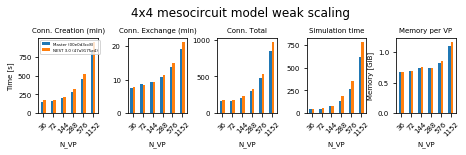

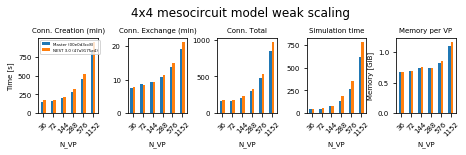

In [46]:
meso_m = pd.read_csv('results/4x4_mesocircuit_00e0d3cc8_daint.csv')
meso_m['Case'] = ['Master (00e0d3cc8)'] * len(meso_m)
meso_3 = pd.read_csv('results/4x4_mesocircuit_3_0_47a9175e4_daint.csv')
meso_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(meso_3)

meso = pd.concat([meso_m, meso_3])

meso = calculate_T_conn_and_memory(meso)
meso
meso_p = plot_compare(meso, 'figures/4x4_mesocircuit_weak_scaling.pdf',
                      #values=['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                      #        'N_conns_sum', 'N_nrns'],
                      legend_loc='upper left',
                      title='4x4 mesocircuit model weak scaling')

meso_p = plot_compare(meso, 'figures/4x4_mesocircuit_weak_scaling.svg',
                      legend_loc='upper left',
                      title='4x4 mesocircuit model weak scaling')

print(meso['N_nrns'])
print(meso['N_conns_sum'])

## Benchmarks with strong scaling

### HPC Benchmark

Conn. Creation (min)                     Conn. Exchange (min)  \
Case         Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
num_tasks                                                                 
1                         3.31                3.78                 3.16   
2                         1.86                1.92                 2.45   
4                         0.91                0.97                 0.95   
8                         0.46                0.49                 0.54   
16                        0.23                0.25                 0.30   
32                        0.11                0.12                 0.54   
64                        0.06                0.07                 0.38   
128                       0.03                0.04                 0.58   

                                    Conn. Total                      \
Case      NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)   
num_tasks                                                             
1                        3.10              6.47                6.88   
2                        1.86              4.31                3.81   
4                        1.01              1.91                2.01   
8                        0.56              1.19                1.06   
16                       0.40              0.56                0.90   
32                       0.21              0.76                0.35   
64                       0.31              0.49                0.52   
128                      0.58              0.66                0.76   

            Simulation time                      
Case      Master (6d8d3047) NEST 3.0 (3aae0a19)  
num_tasks                                        
1                     39.65               40.08  
2                     35.90               18.50  
4                      9.02                9.22  
8                      5.14                4.41  
16                     2.52                2.45  
32                     3.46                2.21  
64                     3.05                2.55  
128                    3.59                3.04

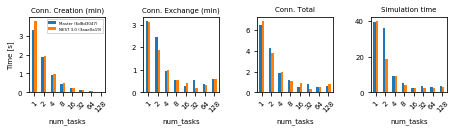

In [19]:
hpc_strong_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_strong_scaling.csv')
hpc_strong_m['Case'] = ['Master (6d8d3047)'] * len(hpc_strong_m)
hpc_strong_3 = pd.read_csv('results/hpc_benchmark_3_0_daint_strong_scaling.csv')
hpc_strong_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(hpc_strong_3)

hpc_strong = pd.concat([hpc_strong_m, hpc_strong_3])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
hpc_strong_p = plot_compare(hpc_strong, 'figures/hpc_benchmark_strong_scaling.pdf', values=values, index='num_tasks',
                            legend_loc='upper right')

hpc_strong_p

### Population model

Conn. Creation (min)                     Conn. Exchange (min)  \
Case         Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
num_tasks                                                                 
1                          NaN                 NaN                  NaN   
2                          NaN                 NaN                  NaN   
4                          NaN                 NaN                  NaN   
8                   118.997228           90.560710            58.489496   
16                   84.344661           54.816632            28.174133   
32                   66.665241           36.752460            14.249193   
64                   57.662544           27.547343             7.238075   
128                  38.256841           23.364649             4.629198   

                                    Conn. Total                      
Case      NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)  
num_tasks                                                            
1                         NaN               NaN                 NaN  
2                         NaN               NaN                 NaN  
4                         NaN               NaN                 NaN  
8                   55.220412        178.294726          148.677884  
16                  26.375661        113.534168           82.126435  
32                  13.635903         81.843442           51.183455  
64                   6.981922         74.926960           35.009812  
128                  3.994257         64.025928           27.819271

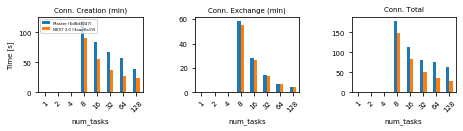

In [20]:
population_strong_m = pd.read_csv('results/population_model_6d8d3047_daint_strong_scaling_in.csv')
population_strong_m['Case'] = ['Master (6d8d3047)'] * len(population_strong_m)
population_strong_3 = pd.read_csv('results/population_model_3_0_daint_strong_scaling_in.csv')
population_strong_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(population_strong_3)

population_strong = pd.concat([population_strong_m, population_strong_3])

population_strong = calculate_T_conn_and_memory(population_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
population_strong_p = plot_compare(population_strong, 'figures/population_model_strong_scaling.pdf', values=values,
                                   index='num_tasks', plot_T_sim=False, legend_loc='upper left')

population_strong_p

### Multi-Area Model

                            git  NUMBER_OF_NODES  TASKS_PER_NODE  NUM_VPS  \
0  GIT: (NEST nest-3@47a9175e4)               32               6      NaN   
1  GIT: (NEST nest-3@47a9175e4)               48               6      NaN   
2  GIT: (NEST nest-3@47a9175e4)               64               6      NaN   
3  GIT: (NEST nest-3@47a9175e4)               80               6      NaN   
4  GIT: (NEST nest-3@47a9175e4)               96               6      NaN   
5  GIT: (NEST nest-3@47a9175e4)              112               6      NaN   
6  GIT: (NEST nest-3@47a9175e4)              128               6      NaN   

   THREADS_PER_TASK  SCALE  NUM_VPS.1  num_tasks  T_network_local  \
0                 6      1        NaN        192        42.877114   
1                 6      1        NaN        288        35.433273   
2                 6      1        NaN        384        32.082029   
3                 6      1        NaN        480        30.123940   
4                 6      1        NaN 

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,Simulation time
Case,NEST 3.0 (47a9175e4),NEST 3.0 (47a9175e4),NEST 3.0 (47a9175e4),NEST 3.0 (47a9175e4)
num_tasks,,,,
192,77.340813,28.159943,105.502340,37.709824
288,69.712029,22.065063,91.779859,44.425755
384,66.715326,18.756371,85.472043,47.280171
480,63.418275,16.319383,79.740380,76.969127
576,63.423330,14.632541,78.058595,76.763005
672,59.374492,12.998581,72.375606,77.170446
768,58.556264,12.688724,71.247433,69.401331


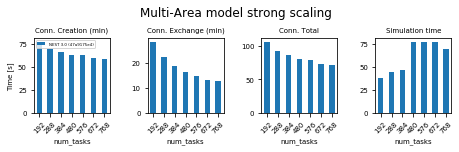

In [47]:
# MAM_strong_m = pd.read_csv('results/multi-area_model_6d8d3047_daint_strong_scaling_in.csv')
# MAM_strong_m['Case'] = ['Master (6d8d3047)'] * len(MAM_strong_m)
MAM_strong_3 = pd.read_csv('results/multi-area_model_3_0_47a9175e4_daint_strong_scaling.csv')
MAM_strong_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(MAM_strong_3)

MAM_strong = pd.concat([MAM_strong_3])

print(MAM_strong)

MAM_strong = calculate_T_conn_and_memory(MAM_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
MAM_strong_p = plot_compare(MAM_strong, 'figures/multi-area_model_strong_scaling.pdf', values=values,
                            index='num_tasks', legend_loc='upper left',
                            title='Multi-Area model strong scaling')

MAM_strong_p

### Attemt to reproduce Jordan et. all (2018) appendix, fig. 4

Trenger en mindre scale

Conn. Creation (min)                     Conn. Exchange (min)  \
Case       Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
threads                                                                 
1                      50.40               54.76                36.70   
3                      30.81               31.98                26.41   
6                      22.64               23.88                21.35   
9                      16.59               17.95                18.61   
18                     12.10               14.02                15.62   
36                      9.08               11.99                16.70   

                                  Conn. Total                      \
Case    NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)   
threads                                                             
1                     36.63             87.69               92.75   
3                     23.89             58.35               57.60   
6                     21.33             44.95               46.84   
9                     18.70             36.05               38.00   
18                    15.60             28.42               31.27   
36                    16.60             26.15               29.17   

          Simulation time                                T_nrns  \
Case    Master (6d8d3047) NEST 3.0 (3aae0a19) Master (6d8d3047)   
threads                                                           
1                  202.97              227.84              0.21   
3                  104.01              110.50              0.28   
6                   54.59               56.75              0.32   
9                   40.05               57.76              0.32   
18                  23.80               25.13              0.36   
36                  15.83               16.32              0.54   

                             
Case    NEST 3.0 (3aae0a19)  
threads                      
1                      0.14  
3                      0.40  
6                      0.39  
9                      0.20  
18                     0.37  
36                     0.43

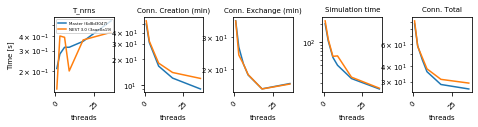

In [21]:
hpc_j_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_strong_scaling_over_threads.csv')
hpc_j_m['Case'] = ['Master (6d8d3047)'] * len(hpc_j_m)
hpc_j_3 = pd.read_csv('results/hpc_benchmark_3_0_daint_strong_scaling_over_threads.csv')
hpc_j_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(hpc_j_3)

hpc_j = pd.concat([hpc_j_m, hpc_j_3])

hpc_j['VSize_nodes_sum'] = [None] * len(hpc_j)
hpc_j['VSize_ini_sum'] = [None] * len(hpc_j)
hpc_j = calculate_T_conn_and_memory(hpc_j)
hpc_j['threads'] = hpc_j['THREADS_PER_TASK']
values=['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']

hpc_j_p = plot_compare(hpc_j, 'figures/hpc_benchmark_strong_scaling_over_threads.pdf', index='threads',
                       values=values, legend_loc='upper left', plot_kind='line', logy=True)

hpc_j_p

## Compare versions

### num. nodes = 1,  num. threads = {1,3,6,9,18,36}, num. vps=36

Conn. Creation (min)                                   \
Case                    2.14    2.16   2.18 Master (6d8d3047)   
threads                                                         
1                      36.44   21.73  17.62             17.42   
3                      47.89   38.73  30.85             30.24   
6                      52.17   51.38  42.25             41.48   
9                      53.47   58.84  43.85             42.44   
18                     54.55   81.97  56.37             56.02   
36                     61.78  124.92  74.22             74.35   

                            Conn. Exchange (min)                \
Case    NEST 3.0 (3aae0a19)                 2.14   2.16   2.18   
threads                                                          
1                     18.83                 0.62  18.79  11.87   
3                     32.47                 0.89  29.74  24.27   
6                     43.56                 0.96  35.99  32.64   
9                     46.28                 0.91  50.30  48.41   
18                    71.54                 1.38  66.25  68.98   
36                   108.66                 1.44  91.19  77.44   

                                                      ...          \
Case    Master (6d8d3047) NEST 3.0 (3aae0a19)         ...           
threads                                               ...           
1                   11.69               11.67         ...           
3                   24.48               23.32         ...           
6                   32.80               31.83         ...           
9                   45.36               45.06         ...           
18                  68.54               73.30         ...           
36                  77.49               77.72         ...           

        Memory per VP                                        \
Case             2.14      2.16      2.18 Master (6d8d3047)   
threads                                                       
1            2.312773  5.072531  3.096897          3.097431   
3            2.028328  4.422857  2.269574          2.295633   
6            1.983972  4.332034  2.121685          2.118519   
9            1.973401  4.311907  2.100494          2.067026   
18           1.963256  4.293865  2.008091          1.997216   
36           1.968212  4.284930  1.989075          1.989090   

                            Simulation time                                    \
Case    NEST 3.0 (3aae0a19)            2.14    2.16    2.18 Master (6d8d3047)   
threads                                                                         
1                  3.097244           85.58   87.81   92.16             89.93   
3                  2.308753          121.11  128.25  126.82            123.51   
6                  2.073484          128.85  131.90  134.71            133.43   
9                  2.098363          124.27  135.43  136.02            129.22   
18                 2.016601          130.37  137.20  137.85            135.70   
36                 2.018070          173.78  187.95  204.53            203.74   

                             
Case    NEST 3.0 (3aae0a19)  
threads                      
1                     98.86  
3                    131.22  
6                    137.56  
9                    135.80  
18                   139.79  
36                   210.48  

[6 rows x 25 columns]

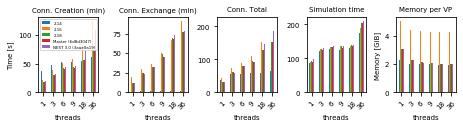

In [22]:
hpc_214 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_214['Case'] = ['2.14']*len(hpc_214)
hpc_216 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_216['Case'] = ['2.16']*len(hpc_216)
hpc_218 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_218['Case'] = ['2.18']*len(hpc_218)
hpc_m   = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_threads_s15.csv')
hpc_m['Case']   = ['Master (6d8d3047)']*len(hpc_m)
hpc_3   = pd.read_csv('results/hpc_benchmark_3_0_daint_threads_s15.csv')
hpc_3['Case']   = ['NEST 3.0 (3aae0a19)']*len(hpc_3)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_m, hpc_3])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['threads'] = hpc_versions['THREADS_PER_TASK']
hpc_versions_p = plot_compare(hpc_versions, 'figures/hpc_different_versions.pdf', index='threads',
                              plot_T_sim=True, legend_loc='upper left',
                              rot=45)
hpc_versions_p

### num. threads = 1, num. nodes = {1, 2, 4, 8, 16, 32}, num. vps = 36

Conn. Creation (min)                                                      \
Case                 2.14   2.16   2.18 Master (6d8d3047) NEST 3.0 (3aae0a19)   
N_VP                                                                            
36                  35.65  21.84  17.56             17.53               18.82   
72                  37.68  21.74  17.36             17.18               19.03   
144                 39.38  21.71  17.38             17.33               18.97   
288                 40.99  22.01  17.39             17.20               19.15   
576                 42.90  21.77  17.39             17.23               19.44   
1152                43.87  21.73  17.37             17.12               20.17   

     Conn. Exchange (min)                                                      \
Case                 2.14   2.16   2.18 Master (6d8d3047) NEST 3.0 (3aae0a19)   
N_VP                                                                            
36                   0.60  18.22  11.78             11.96               11.71   
72                   0.63  18.84  11.78             11.91               12.04   
144                  0.58  22.50  12.36             12.13               12.12   
288                  0.67  22.05  13.03             13.41               13.53   
576                  0.90  24.56  15.09             15.27               15.39   
1152                 1.28  29.25  19.17             20.06               18.79   

             ...         Memory per VP                                        \
Case         ...                  2.14      2.16      2.18 Master (6d8d3047)   
N_VP         ...                                                               
36           ...              2.312611  5.072531  3.096897          3.097431   
72           ...              2.327074  5.073708  3.107514          3.108052   
144          ...              2.707514  5.075892  3.109698          3.110236   
288          ...              3.149024  5.080248  3.114054          3.114592   
576          ...              3.144015  5.108859  3.578192          3.578964   
1152         ...              3.161597  5.123802  4.092529          4.091714   

                         Simulation time                                    \
Case NEST 3.0 (3aae0a19)            2.14    2.16    2.18 Master (6d8d3047)   
N_VP                                                                         
36              3.097243           82.85   88.38   90.13             90.82   
72              3.107861           84.19   87.63   90.85             90.70   
144             3.110045           87.78   92.08   95.31             95.48   
288             3.114401           97.88  105.33  105.49            106.74   
576             3.577908          110.44  119.03  128.16            129.06   
1152            4.098217          140.54  163.31  172.90            176.92   

                          
Case NEST 3.0 (3aae0a19)  
N_VP                      
36                 97.74  
72                 97.94  
144               102.74  
288               114.11  
576               137.00  
1152              234.30  

[6 rows x 25 columns]

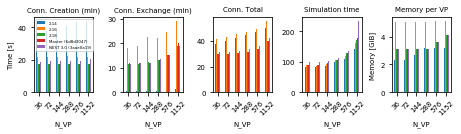

In [23]:
hpc_214_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214_t1['Case'] = ['2.14']*len(hpc_214_t1)
hpc_216_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216_t1['Case'] = ['2.16']*len(hpc_216_t1)
hpc_218_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218_t1['Case'] = ['2.18']*len(hpc_218_t1)
hpc_m_t1   = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_t1_s15.csv')
hpc_m_t1['Case']   = ['Master (6d8d3047)']*len(hpc_m_t1)
hpc_3_t1   = pd.read_csv('results/hpc_benchmark_3_0_daint_t1_s15.csv')
hpc_3_t1['Case']   = ['NEST 3.0 (3aae0a19)']*len(hpc_3_t1)

hpc_versions_t1 = pd.concat([hpc_214_t1, hpc_216_t1, hpc_218_t1, hpc_m_t1, hpc_3_t1])

hpc_versions_t1 = calculate_T_conn_and_memory(hpc_versions_t1)
hpc_versions_t1_p = plot_compare(hpc_versions_t1, 'figures/hpc_different_versions_t1.pdf', legend_loc='upper left',
                                 rot=45)

hpc_versions_t1_p